In [4]:
!pip install torchvision


  Using cached torchvision-0.15.2-cp39-cp39-win_amd64.whl (1.2 MB)



















In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid', font_scale=1.2)

In [2]:
DATA_DIR = '/kaggle/input/anime-faces'

In [3]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))


In [5]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

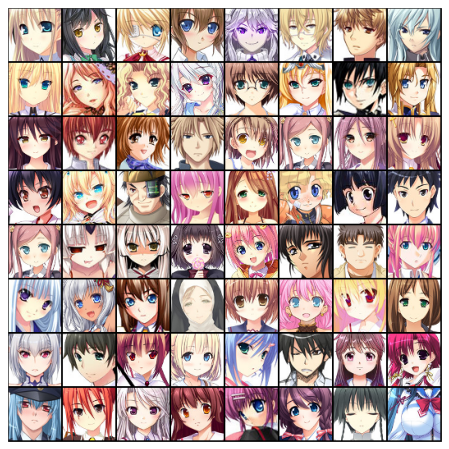

In [8]:
show_batch(train_dl)

In [9]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

In [12]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [13]:
discriminator = to_device(discriminator, device)

In [14]:
latent_size = 128

In [15]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


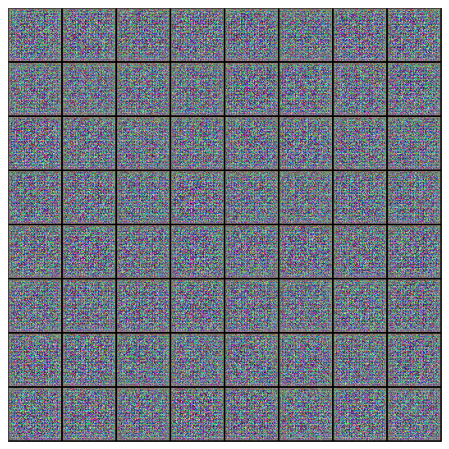

In [16]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [17]:
generator = to_device(generator, device)

In [18]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [19]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [20]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [21]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [22]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 55

In [23]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [1/55], loss_g: 6.0712, loss_d: 0.6992, real_score: 0.7985, fake_score: 0.2164


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [2/55], loss_g: 4.3445, loss_d: 0.8678, real_score: 0.7235, fake_score: 0.2761


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [3/55], loss_g: 4.3875, loss_d: 0.7644, real_score: 0.7471, fake_score: 0.2460


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [4/55], loss_g: 4.6416, loss_d: 0.7498, real_score: 0.7594, fake_score: 0.2399


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [5/55], loss_g: 4.7450, loss_d: 0.6834, real_score: 0.7673, fake_score: 0.2306


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [6/55], loss_g: 5.0834, loss_d: 0.6168, real_score: 0.7873, fake_score: 0.2084


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [7/55], loss_g: 5.3992, loss_d: 0.5348, real_score: 0.8095, fake_score: 0.1875


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [8/55], loss_g: 5.5800, loss_d: 0.5063, real_score: 0.8189, fake_score: 0.1770


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [9/55], loss_g: 5.8163, loss_d: 0.5460, real_score: 0.8155, fake_score: 0.1807


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [10/55], loss_g: 5.6648, loss_d: 0.4424, real_score: 0.8374, fake_score: 0.1596


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [11/55], loss_g: 5.8282, loss_d: 0.4859, real_score: 0.8359, fake_score: 0.1623


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [12/55], loss_g: 6.2060, loss_d: 0.3657, real_score: 0.8636, fake_score: 0.1333


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [13/55], loss_g: 6.1112, loss_d: 0.3195, real_score: 0.8792, fake_score: 0.1196


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [14/55], loss_g: 6.6811, loss_d: 0.3607, real_score: 0.8751, fake_score: 0.1219


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [15/55], loss_g: 6.2794, loss_d: 0.2993, real_score: 0.8880, fake_score: 0.1108


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [16/55], loss_g: 6.8303, loss_d: 0.3495, real_score: 0.8804, fake_score: 0.1177


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [17/55], loss_g: 6.3861, loss_d: 0.3281, real_score: 0.8840, fake_score: 0.1131


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [18/55], loss_g: 6.6039, loss_d: 0.3971, real_score: 0.8787, fake_score: 0.1234


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [19/55], loss_g: 5.8634, loss_d: 0.2923, real_score: 0.8897, fake_score: 0.1074


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [20/55], loss_g: 6.2614, loss_d: 0.3792, real_score: 0.8801, fake_score: 0.1193


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [21/55], loss_g: 6.0069, loss_d: 0.3299, real_score: 0.8847, fake_score: 0.1129


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [22/55], loss_g: 6.0927, loss_d: 0.3049, real_score: 0.8895, fake_score: 0.1094


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [23/55], loss_g: 6.3490, loss_d: 0.3511, real_score: 0.8831, fake_score: 0.1137


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [24/55], loss_g: 5.7582, loss_d: 0.3554, real_score: 0.8803, fake_score: 0.1210


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [25/55], loss_g: 5.9754, loss_d: 0.3191, real_score: 0.8883, fake_score: 0.1104


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [26/55], loss_g: 6.0898, loss_d: 0.3980, real_score: 0.8779, fake_score: 0.1208


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [27/55], loss_g: 5.2995, loss_d: 0.2538, real_score: 0.9006, fake_score: 0.0992


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [28/55], loss_g: 5.6850, loss_d: 0.3636, real_score: 0.8814, fake_score: 0.1167


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [29/55], loss_g: 5.3474, loss_d: 0.2538, real_score: 0.9028, fake_score: 0.0955


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [30/55], loss_g: 5.3705, loss_d: 0.3474, real_score: 0.8893, fake_score: 0.1118


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [31/55], loss_g: 5.9398, loss_d: 0.3763, real_score: 0.8817, fake_score: 0.1177


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [32/55], loss_g: 4.9818, loss_d: 0.2516, real_score: 0.9047, fake_score: 0.0934


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [33/55], loss_g: 5.2671, loss_d: 0.2776, real_score: 0.9010, fake_score: 0.0979


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [34/55], loss_g: 5.4689, loss_d: 0.3236, real_score: 0.8921, fake_score: 0.1077


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [35/55], loss_g: 5.3602, loss_d: 0.2551, real_score: 0.9061, fake_score: 0.0931


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [36/55], loss_g: 5.4879, loss_d: 0.3608, real_score: 0.8836, fake_score: 0.1163


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [37/55], loss_g: 4.9883, loss_d: 0.2291, real_score: 0.9111, fake_score: 0.0875


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [38/55], loss_g: 5.1951, loss_d: 0.4978, real_score: 0.8705, fake_score: 0.1308


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [39/55], loss_g: 4.7241, loss_d: 0.2770, real_score: 0.9054, fake_score: 0.0938


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [40/55], loss_g: 5.0504, loss_d: 0.2635, real_score: 0.9046, fake_score: 0.0936


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [41/55], loss_g: 4.8244, loss_d: 0.1920, real_score: 0.9223, fake_score: 0.0777


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [42/55], loss_g: 5.2029, loss_d: 0.4113, real_score: 0.8809, fake_score: 0.1188


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [43/55], loss_g: 4.7976, loss_d: 0.2080, real_score: 0.9184, fake_score: 0.0805


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [44/55], loss_g: 5.0369, loss_d: 0.3944, real_score: 0.8871, fake_score: 0.1132


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [45/55], loss_g: 4.7345, loss_d: 0.2458, real_score: 0.9176, fake_score: 0.0815


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [46/55], loss_g: 4.9676, loss_d: 0.3249, real_score: 0.9050, fake_score: 0.0961


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [47/55], loss_g: 4.9074, loss_d: 0.2242, real_score: 0.9132, fake_score: 0.0862


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [48/55], loss_g: 5.2816, loss_d: 0.3139, real_score: 0.9021, fake_score: 0.0976


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [49/55], loss_g: 4.8432, loss_d: 0.3111, real_score: 0.9048, fake_score: 0.0945


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [50/55], loss_g: 4.6608, loss_d: 0.1656, real_score: 0.9319, fake_score: 0.0678


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [51/55], loss_g: 4.8888, loss_d: 0.3068, real_score: 0.9034, fake_score: 0.0958


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [52/55], loss_g: 4.7157, loss_d: 0.2980, real_score: 0.9159, fake_score: 0.0809


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [53/55], loss_g: 4.9970, loss_d: 0.2704, real_score: 0.9097, fake_score: 0.0930


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [54/55], loss_g: 4.6240, loss_d: 0.1415, real_score: 0.9396, fake_score: 0.0600


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [55/55], loss_g: 4.8647, loss_d: 0.2971, real_score: 0.9112, fake_score: 0.0886

Saving generated-images-0055.png


In [24]:
losses_g, losses_d, real_scores, fake_scores = history

In [25]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

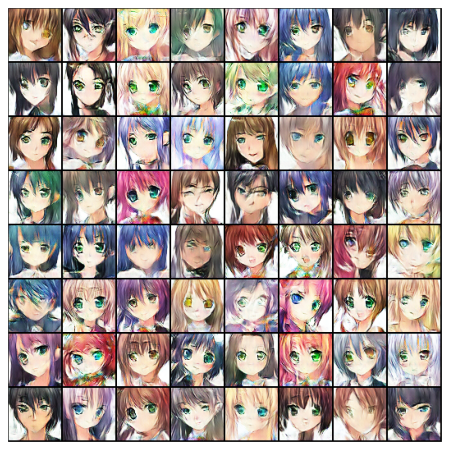

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

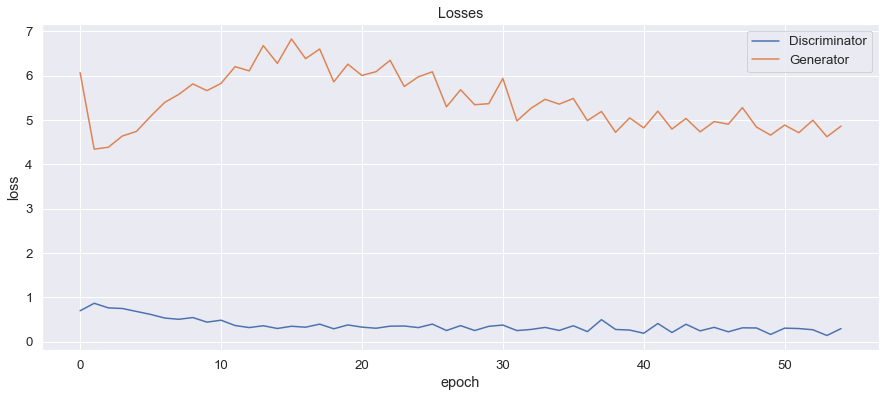

In [27]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

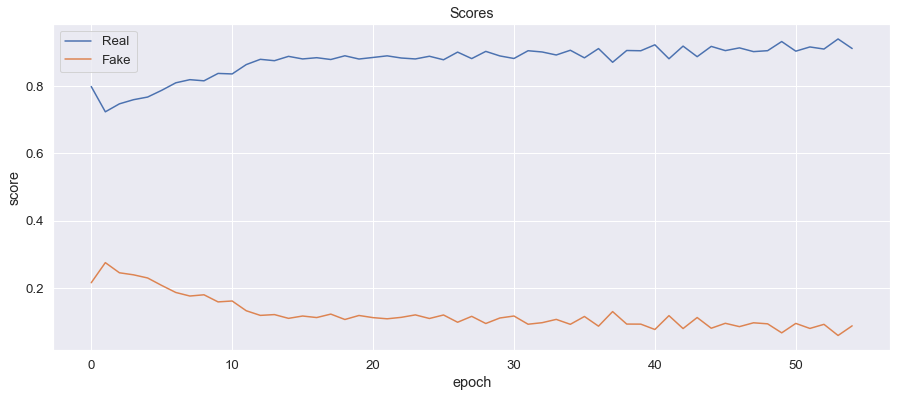

In [28]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');